# Audio Classification 

**importing necessary liabraries**

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
filename = 'test_audio/dog.wav'

**displaying a sample audio using librosa and matplotlib**

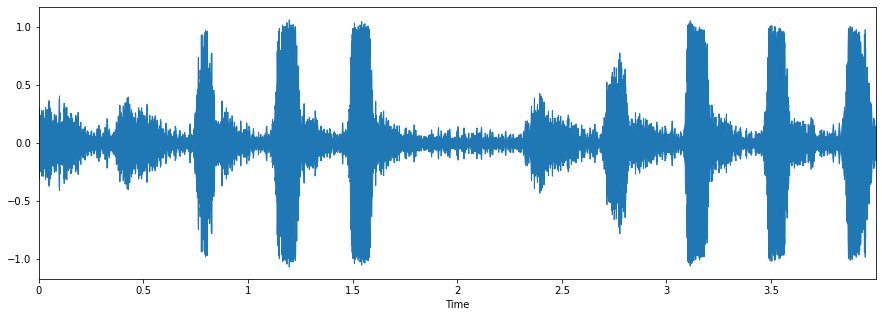

In [3]:
plt.figure(figsize=(15,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

**reading csv file for features and labels**

In [4]:
import pandas as pd

metadata=pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')

metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


**there are 10 labels as follows**

In [5]:
metadata['class'].value_counts()

air_conditioner     1000
street_music        1000
engine_idling       1000
children_playing    1000
drilling            1000
jackhammer          1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

**defining a method to extract features from audio sample
(*converting to array*)**

In [6]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [7]:
audio_dataset_path='UrbanSound8K/UrbanSound8K/audio/'

**reading all the audio data**

In [8]:
import os
import numpy as np
from tqdm import tqdm

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [02:37, 19.56it/s]C:\Users\sufiyan\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8326it [06:20, 29.06it/s]C:\Users\sufiyan\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\sufiyan\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [06:37, 21.97it/s]


**making a dataframe of features and labels**

In [9]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.091335,...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265697,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


In [10]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

**we have total 8732 features and 10 labels**

In [11]:
y=np.array(pd.get_dummies(y))

In [12]:
print(X.shape, y.shape)

(8732, 40) (8732, 10)


**splitting into training and validation data**

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [14]:
X_train.shape

(6985, 40)

In [15]:
X_test.shape

(1747, 40)

In [16]:
y_train.shape

(6985, 10)

In [17]:
y_test.shape

(1747, 10)

In [18]:
num_labels=y.shape[1]

### Building Classifier

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

In [20]:
model=Sequential()
###first layer
model.add(Dense(512,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [21]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='final_model.h5', 
                               verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/100
196/219 [=========================>....] - ETA: 0s - loss: 6.8699 - accuracy: 0.1445
Epoch 00001: val_loss improved from inf to 2.21262, saving model to final_model.h5
219/219 [==============================] - 1s 3ms/step - loss: 6.4049 - accuracy: 0.1446 - val_loss: 2.2126 - val_accuracy: 0.1643
Epoch 2/100
209/219 [===========================>..] - ETA: 0s - loss: 2.2923 - accuracy: 0.1485
Epoch 00002: val_loss improved from 2.21262 to 2.14462, saving model to final_model.h5
219/219 [==============================] - 0s 2ms/step - loss: 2.2918 - accuracy: 0.1495 - val_loss: 2.1446 - val_accuracy: 0.2129
Epoch 3/100
200/219 [==========================>...] - ETA: 0s - loss: 2.1852 - accuracy: 0.1948
Epoch 00003: val_loss improved from 2.14462 to 2.05361, saving model to final_model.h5
219/219 [==============================] - 1s 2ms/step - loss: 2.1851 - accuracy: 0.1956 - val_loss: 2.0536 - val_accuracy: 0.2799
Epoch 4/100
197/219 [=========================>....] - ETA:

219/219 [==============================] - 1s 2ms/step - loss: 0.6696 - accuracy: 0.7854 - val_loss: 0.5224 - val_accuracy: 0.8340
Epoch 55/100
194/219 [=========================>....] - ETA: 0s - loss: 0.6438 - accuracy: 0.7875
Epoch 00055: val_loss did not improve from 0.52236
219/219 [==============================] - 0s 2ms/step - loss: 0.6397 - accuracy: 0.7900 - val_loss: 0.5532 - val_accuracy: 0.8334
Epoch 56/100
194/219 [=========================>....] - ETA: 0s - loss: 0.6205 - accuracy: 0.7975
Epoch 00056: val_loss did not improve from 0.52236
219/219 [==============================] - 0s 2ms/step - loss: 0.6257 - accuracy: 0.7956 - val_loss: 0.5385 - val_accuracy: 0.8363
Epoch 57/100
196/219 [=========================>....] - ETA: 0s - loss: 0.6071 - accuracy: 0.8040
Epoch 00057: val_loss did not improve from 0.52236
219/219 [==============================] - 0s 2ms/step - loss: 0.6209 - accuracy: 0.7999 - val_loss: 0.5242 - val_accuracy: 0.8403
Epoch 58/100
204/219 [=======

Epoch 83/100
218/219 [============================>.] - ETA: 0s - loss: 0.5185 - accuracy: 0.8336
Epoch 00083: val_loss did not improve from 0.44967
219/219 [==============================] - 1s 2ms/step - loss: 0.5182 - accuracy: 0.8336 - val_loss: 0.4568 - val_accuracy: 0.8620
Epoch 84/100
196/219 [=========================>....] - ETA: 0s - loss: 0.5390 - accuracy: 0.8265
Epoch 00084: val_loss improved from 0.44967 to 0.44288, saving model to final_model.h5
219/219 [==============================] - 1s 2ms/step - loss: 0.5294 - accuracy: 0.8289 - val_loss: 0.4429 - val_accuracy: 0.8718
Epoch 85/100
196/219 [=========================>....] - ETA: 0s - loss: 0.5264 - accuracy: 0.8383
Epoch 00085: val_loss did not improve from 0.44288
219/219 [==============================] - 0s 2ms/step - loss: 0.5287 - accuracy: 0.8362 - val_loss: 0.4655 - val_accuracy: 0.8609
Epoch 86/100
200/219 [==========================>...] - ETA: 0s - loss: 0.5204 - accuracy: 0.8338
Epoch 00086: val_loss impr

**loading the best model and predicting the output class**

In [26]:
from tensorflow import keras
import numpy as np
model = keras.models.load_model('final_model.h5')

filename = 'test_audio/car_horn.wav'
prediction_feature=features_extractor(filename)
prediction_feature= np.expand_dims(prediction_feature, axis = 0)
value = model.predict_classes(prediction_feature)[0]
labels = []
for i in extracted_features_df['class']:
    if i not in labels:
        labels.append(i)
        
labels = sorted(labels)
labels[value]

'car_horn'